In [1]:
using ReproductionNumbers, DataFrames, ExcelFiles, Plots, CSV, Statistics

In [31]:
case_name   =   "estimated-cases-20200511"
file_name   =   "data/COVID19_Deutschland.xlsx"
sheet_name  =   "Nowcast_R"
days_col    =   "Datum RKI-Tagesbericht"
data_col    =   "N(RKI-H)"

"N(RKI-H)"

In [22]:
function get_data(df::DataFrame; days_col::String, data_col::String, kind::String)
    @assert kind ∈ ( "R", "cases" ) "kind $kind not supported"
    index = df[!, days_col]
    data = df[!, data_col]
    inds = .!ismissing.(data)

    DataFrame( Dict("days" => Vector(index[inds]), "$(kind)" => Vector(data[inds]) ) )
end
function build_R_acausal_new(df::DataFrame; past::Int, future::Int, k_gen::Int)
    df_N_temp, df_R = build_R(df, past = past, future = future, k_gen = k_gen)
    df_N_acausal = compute_cases_acausal_new(df, df_R, past = past, future = future, k_gen = k_gen)
    relevant_days = df_N_acausal.days .- k_gen

    num = df_N_acausal.cases
    den = df_N_temp[ first(relevant_days) .<= df_N_temp.days .<= last(relevant_days), :cases]
    R = compute_R(num, den)

    df_N_acausal, DataFrame(days = df_N_acausal.days, R = R)
end

function compute_cases_acausal_new(df_cases::DataFrame, df_reproduction::DataFrame; past::Int, future::Int, k_gen::Int)
    start_date = first(df_reproduction).days - past
    end_date = last(df_reproduction).days + future

    @assert start_date ∈ df_cases.days "missing case numbers from the past (required start date: $(start_date))"
    @assert end_date ∈ df_cases.days "missing case numbers from the future (required end date: $(end_date))"

    N = Vector{Float64}()
    for row in eachrow(df_reproduction)
        day, R = row.days, row.R

        w = get_weights(R, past, future, k_gen)
        cases = get_values_new(df_cases, day, past, future, column = :cases)

        push!(N, mean(cases .* w))
    end

    DataFrame(days = df_reproduction.days .+ past, cases = N)
end

function get_values_new(df::DataFrame, present, past::Int, future::Int; column::Symbol = :cases)
    df[ present - past .<= df.days .<= present + future , column]
end

function mae(pred::Vector, gt::CSV.Column{Float64,Float64})
   mean(abs.(pred - gt))
end

function parameter_search(df::DataFrame, past::Array{Int64,1}, future::Array{Int64,1}, k_gen:: Array{Int64,1}, data_col::String)
    result_r = DataFrame(Method = String[], Case= String[], Past = Int[], Future = Int[], MAE = Float64[], k_gen=Int[])
    result_n = DataFrame(Method = String[], Case= String[], Past = Int[], Future = Int[], MAE = Float64[], k_gen=Int[])
    df_cases = get_data(df, days_col = "k", data_col = data_col, kind = "cases")
    r_true = df[!, "true R"]
    for k in k_gen
        for i in past
            if i > k
                break
            end
            for j in future
                if j > k
                    break
                end
                neu_h_N, neu_h_R = build_R(df_cases; past = i, future = j, k_gen = k)
                error = mean(abs.(neu_h_R.R[max(1, 11 - i - j):length(neu_h_R.R)]- r_true[(max(1,11 - i -j)+ k + i):(length(r_true)- j)]))
                push!(result_r, ["Neu-h", data_col, i, j, error, k])
                neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = i, future = j, k_gen = k)
                error = mean(abs.(neu_ha_R.R[max(1, 11 - i - j):length(neu_h_R.R)] -r_true[(max(1,11 - i -j)+ k + i):(length(r_true)- j)]))
                push!(result_r, ["Neu-ha", data_col, i, j, error, k])
            end
        end
    end
    return result_r
end

parameter_search (generic function with 1 method)

In [32]:
k_gen = 4
df = DataFrame(load(file_name, sheet_name))
df_cases = get_reference_data(df, days_col = days_col, data_col = data_col, kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)


gr()
plot(rki_h_R.days, rki_h_R.R, marker=:x, label="RKI-H")
plot!(neu_h_R.days, neu_h_R.R, marker=:c, label="NEU-H")
plot!(neu_ha_R.days, neu_ha_R.R, marker=:s, label="NEU-HA")

MethodError: MethodError: Cannot `convert` an object of type Float64 to an object of type Dates.Date
Closest candidates are:
  convert(::Type{Dates.Date}, !Matched::Dates.DateTime) at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Dates\src\conversions.jl:31
  convert(::Type{Dates.Date}, !Matched::Dates.Day) at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Dates\src\conversions.jl:36
  convert(::Type{Dates.Date}, !Matched::PyCall.PyObject) at C:\Users\bened\.julia\packages\PyCall\zqDXB\src\pydates.jl:156
  ...

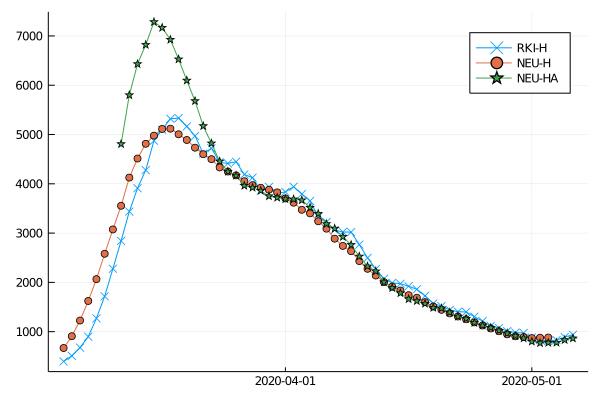

In [5]:
gr()
plot(rki_h_N.days, rki_h_N.cases, marker=:x, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, marker=:c, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, marker=:s, label="NEU-HA")

## No delay pattern

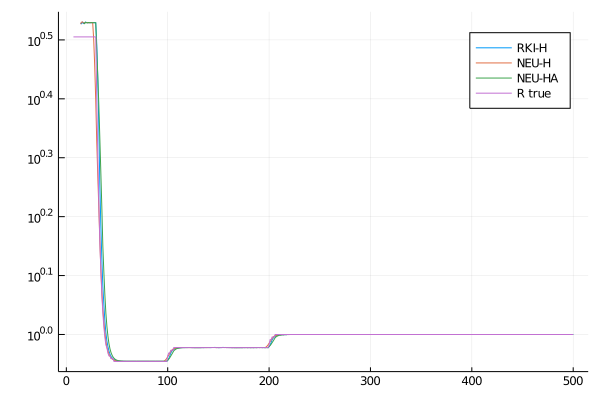

In [6]:
df = CSV.read("data/synth_0.9_0.95_1_day.csv")
r_true = df[!, "true R"]
index = df[!, "k"]
cases = df[!, "New cases (True)"]
df_cases = get_data(df, days_col = "k", data_col = "New cases (True)", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)

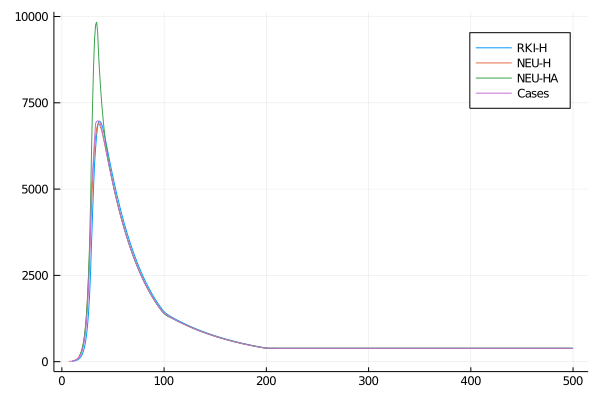

In [7]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")

## Delayed by 10

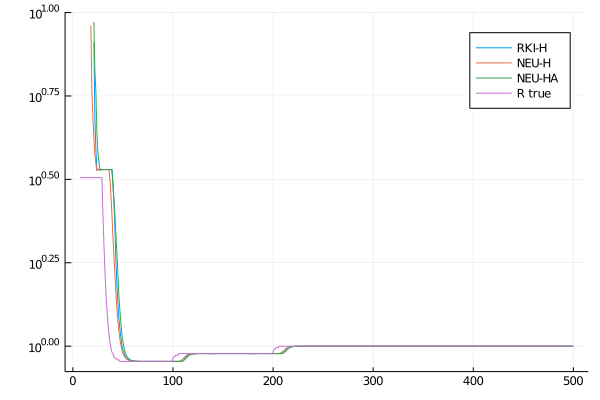

In [8]:
df_cases = get_data(df, days_col = "k", data_col = "reported cases", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)

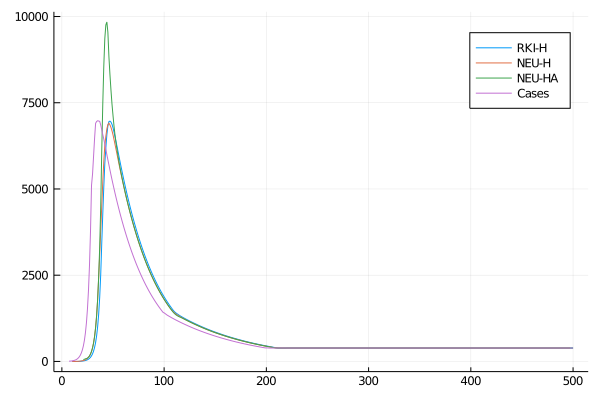

In [9]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")

## 1 Day delay pattern

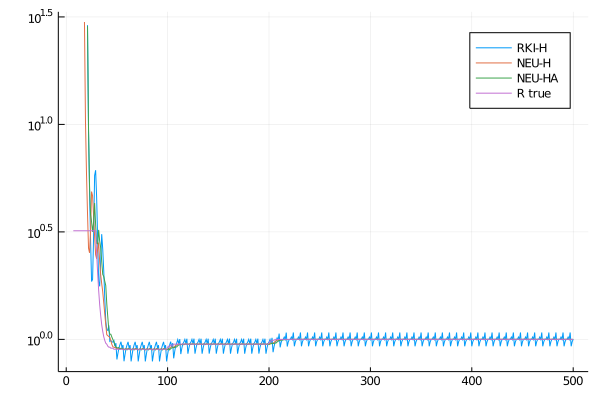

In [10]:
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179


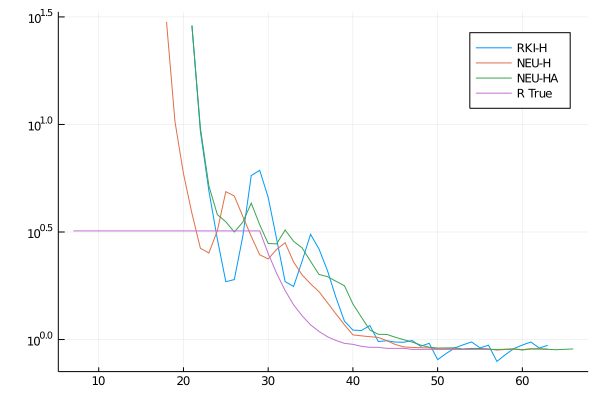

In [11]:
gr()
plot(rki_h_R.days[1:50], rki_h_R.R[1:50], label="RKI-H",yscale=:log)
plot!(neu_h_R.days[1:50], neu_h_R.R[1:50], label="NEU-H",yscale=:log)
plot!(neu_ha_R.days[1:50], neu_ha_R.R[1:50], label="NEU-HA",yscale=:log)
plot!(index[1:50], r_true[1:50], label="R True",yscale=:log)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179


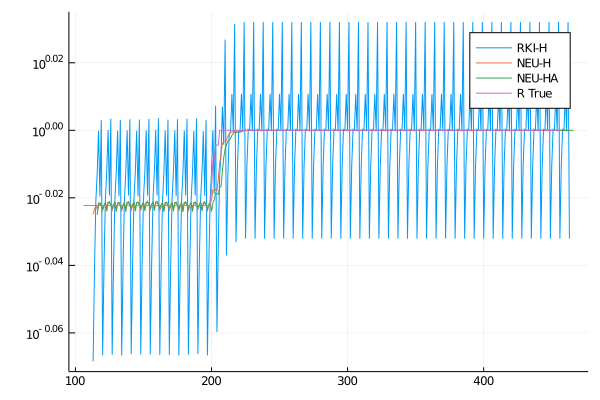

In [12]:
gr()
plot(rki_h_R.days[100:450], rki_h_R.R[100:450], label="RKI-H")
plot!(neu_h_R.days[100:450], neu_h_R.R[100:450], label="NEU-H")
plot!(neu_ha_R.days[100:450], neu_ha_R.R[100:450], label="NEU-HA")
plot!(index[100:450], r_true[100:450], label="R True",yscale=:log)

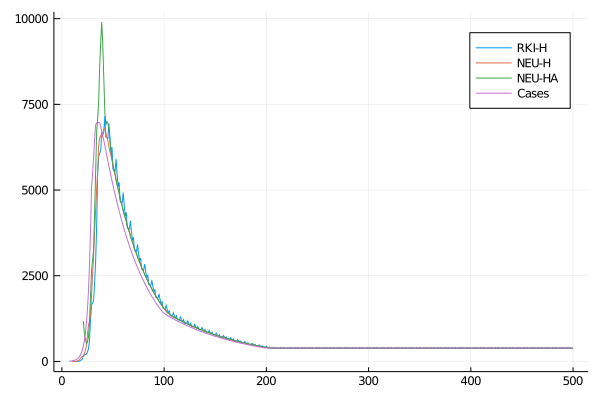

In [13]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")

In [14]:
result = parameter_search(df, collect(1:5), collect(1:5),  collect(1:9), "delayed")
CSV.write("mae_1day.csv", result)
result

,Method,Case,Past,Future,MAE,k_gen
,String,String,Int64,Int64,Float64,Int64
1,Neu-h,delayed,1,1,0.114017,1
2,Neu-ha,delayed,1,1,0.269615,1
3,Neu-h,delayed,1,1,0.102032,2
4,Neu-ha,delayed,1,1,1.09208,2
5,Neu-h,delayed,1,2,0.089779,2
6,Neu-ha,delayed,1,2,0.192811,2
7,Neu-h,delayed,2,1,0.0877294,2
8,Neu-ha,delayed,2,1,0.637003,2
9,Neu-h,delayed,2,2,0.119385,2


# 2-Day Delay pattern

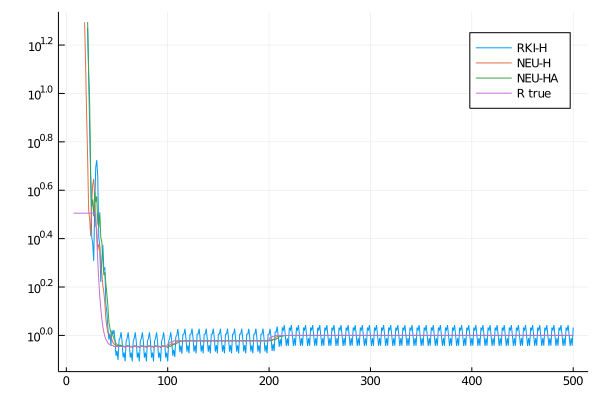

In [15]:
df = CSV.read("data/synth_0.9_0.95_1_2day.csv")
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


In [16]:
result = parameter_search(df, collect(1:10), collect(1:10),  collect(1:10), "delayed")
CSV.write("mae_2day.csv", result)
result

,Method,Case,Past,Future,MAE,k_gen
,String,String,Int64,Int64,Float64,Int64
1,Neu-h,delayed,1,1,0.121719,1
2,Neu-ha,delayed,1,1,0.523941,1
3,Neu-h,delayed,1,1,0.0982314,2
4,Neu-ha,delayed,1,1,0.749487,2
5,Neu-h,delayed,1,2,0.0864459,2
6,Neu-ha,delayed,1,2,0.197179,2
7,Neu-h,delayed,2,1,0.0839311,2
8,Neu-ha,delayed,2,1,0.418738,2
9,Neu-h,delayed,2,2,0.0870856,2


# Weekend Delay Pattern

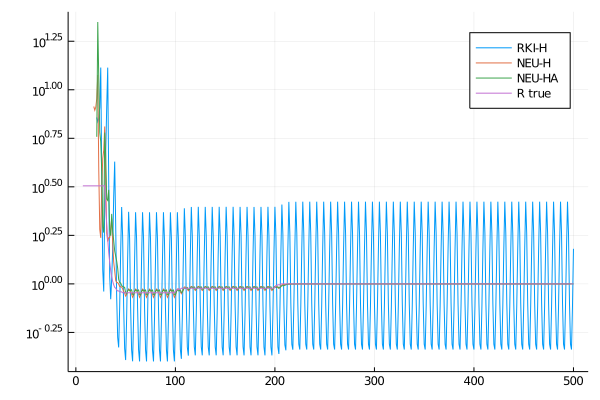

In [17]:
df = CSV.read("data/synth_0.9_0.95_1_weekend.csv")
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


In [18]:
result = parameter_search(df, collect(1:10), collect(1:10),  collect(1:10), "delayed")
CSV.write("mae_weekend.csv", result)
result

,Method,Case,Past,Future,MAE,k_gen
,String,String,Int64,Int64,Float64,Int64
1,Neu-h,delayed,1,1,0.55471,1
2,Neu-ha,delayed,1,1,0.517579,1
3,Neu-h,delayed,1,1,0.993815,2
4,Neu-ha,delayed,1,1,3.0237,2
5,Neu-h,delayed,1,2,0.503142,2
6,Neu-ha,delayed,1,2,0.753143,2
7,Neu-h,delayed,2,1,0.49974,2
8,Neu-ha,delayed,2,1,1.36585,2
9,Neu-h,delayed,2,2,0.383576,2


In [19]:
neu_h_N, neu_h_R = build_R(df_cases; past = 5, future = 5, k_gen = 5)
length(index[(1 +5+ 5) : (494 - 5)]), length(neu_h_R.R)
index[(max(1, 11 - 2 - 1) + 3 + 2):(length(r_true)- 2)]

480-element Array{Int64,1}:
  19
  20
  21
  22
  23
  24
  25
  26
  27
  28
  29
  30
  31
   ⋮
 487
 488
 489
 490
 491
 492
 493
 494
 495
 496
 497
 498

In [20]:
neu_h_N, neu_h_R = build_R(df_cases; past = 2, future = 1, k_gen = 3)
neu_h_R.days[max(1, 11 -1 -2):length(neu_h_R.R)]
#neu_h_R.R[max(1, 11 -1 - 2):length(neu_h_R.R)]

#error = mean(abs.(neu_h_R.R[max(1, 11 - 1 - 1):length(neu_h_R.R)]- r_true[max(10 + 2, 1 +1):(length(r_true)- 1)]))
#push!(result_r, ["Neu-h", data_col, i, j, error])
#neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = i, future = j, k_gen = k)

#error = mean(abs.(neu_ha_R.R[min(0, 11 - i - j):length(neu_h_R.R)] -r_true[max(11,1 + k + i):(length(r_true)- j)]))


481-element Array{Int64,1}:
  19
  20
  21
  22
  23
  24
  25
  26
  27
  28
  29
  30
  31
   ⋮
 488
 489
 490
 491
 492
 493
 494
 495
 496
 497
 498
 499